# Numerical Methods 1
### [Gerard Gorman](http://www.imperial.ac.uk/people/g.gorman), [Matthew Piggott](http://www.imperial.ac.uk/people/m.d.piggott), [Nicolas Barral](http://www.imperial.ac.uk/people/n.barral)

# Lecture 7: Numerical Linear Algebra III

## Learning objectives:

* Ill-conditioned matrices (matrix norms and condition number)
* Direct vs iterative/indirect methods
* Example iterative algorithm: the Jacobi and Gauss-Seidel methods
* Sparse matrices and a pointer to more advanced algorithms (supplementary readings)

## Ill-conditioned matrices

The conditioning (or lack of, i.e. the ill-conditioning) of matrices we are trying to invert (to obtain the inverse, or to find the solution to a linear matrix system) is incredibly important for the success of any algorithm.

When we started talking about matrices we noted that as long as the matrix is non-singular, i.e. $\det(A)\ne 0$ then an inverse exists, and a linear system with that $A$ has a unique solution.

But what happens when we consider a matrix that is nearly singular, i.e. $\det(A)$ is very small?

Well smallness is a relative term and so we need to ask the question of how large or small $\det(A)$ is compared to something.

That something is the *norm* of the matrix.

#### Vector norms

Just as for vectors $\pmb{v}$ (assumed a $n\times 1$ column vector) where we have multiple possible norms to help us decide quantify the magnitude of a vector:

\begin{align}
\|\pmb{v}\|_2 & = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2} = \left(\sum_{i=1}^n v_i^2 \right)^{1/2}, &\quad{\textrm{the two-norm or Euclidean norm}}\\
\|\pmb{v}\|_1  & = |v_1| + |v_2| + \ldots + |v_n| = \sum_{i=1}^n |v_i|, &\quad{\textrm{the one-norm or taxi-cab norm}}\\
\|\pmb{v}\|_{\infty}  &= \max\{|v_1|,|v_2|, \ldots, |v_n| = \max_{i=1}^n |v_i|, &\quad{\textrm{the max-norm or infinity norm}}
\end{align}

#### Matrix norms

We can define measures of the size of matrices, e.g. for $A$ which for complete generality we will assume is of shape $m\times n$:

\begin{align}
\|A\|_F & = \left(\sum_{i=1}^m \sum_{j=1}^n A_{ij}^2 \right)^{1/2}, &\quad{\textrm{the matrix two-norm or Euclidean or Frobenius norm}}\\
\|A\|_{\infty} & = \max_{i=1}^m \sum_{j=1}^n|A_{i,j}|, &\quad{\textrm{the maximum absolute row-sum norm}}\\
\end{align}

Note that while the vector and matrix norms give different results, they are consistent or equivalent in that they are always within a constant factor of one another (a result that is true for finite-dimensional or discrete problems as here). This means we don't really need to worry too much about which norm we're using.

In [1]:
import numpy
from scipy import linalg
A=numpy.array([[10., 2., 1.],[6., 5., 4.],[1., 4., 7.]])
print A

[[ 10.   2.   1.]
 [  6.   5.   4.]
 [  1.   4.   7.]]


In [2]:
print linalg.norm(A)

15.748015748


In [3]:
# the Frobenius norm - the default
print linalg.norm(A,'fro')        

15.748015748


In [4]:
# the maximum absolute row-sum
print linalg.norm(A,numpy.inf)    

15.0


In [5]:
# the maximum absolute column-sum
print linalg.norm(A,1)            

17.0


In [6]:
# the two-norm - note not the same as the Frobenius norm - also termed the spectral norm
print linalg.norm(A,2)            

13.7930910986


In [7]:
print numpy.sqrt(numpy.real((numpy.max(linalg.eigvals(numpy.dot(A.T,A))))))

13.7930910986


### <span style="color:blue">Exercise 7.1: matrix norms</span>

Write some code to explicitly compute the two matrix norms defined mathematically above and compare against the values found above using in-built scipy functions.

Based on the above code and comments, what is the mathematical definition of the 1-norm and the 2-norm?


In [21]:
import numpy as np
import scipy.linalg as sl


def frob(A):
    m, n = A.shape
    squsum = 0.
    for i in range(m):
        for j in range(n):
            squsum += A[i,j]**2
    return np.sqrt(squsum)


def mars(A):
    m, n = A.shape
    maxarsum = 0.
    for i in range(m):
        arsum = np.sum(np.abs(A[i]))
        maxarsum = arsum if arsum > maxarsum else maxarsum
    return maxarsum


A = numpy.array([[10., 2., 1.],
                 [6., 5., 4.],
                 [1., 4., 7.]])
frob(A) == sl.norm(A,'fro') and mars(A) == sl.norm(A,numpy.inf)

True

### Matrix conditioning

The (ill-)conditioning of a matrix is measured with the matrix condition number:

$$\textrm{cond}(A) = \|A\|\|A^{-1}\|$$

If this is close to one then $A$ is well-conditioned, and it increases with the degree of ill-conditioning, reaching infinity for a singular matrix.

In [1]:
import numpy
from scipy import linalg
A=numpy.array([[10., 2., 1.],[6., 5., 4.],[1., 4., 7.]])
print(A)
print(numpy.linalg.cond(A))
print(linalg.norm(A,2)*linalg.norm(linalg.inv(A),2))  # so the default condition number uses the matrix two-norm
print(numpy.linalg.cond(A,'fro'))
print(linalg.norm(A,'fro')*linalg.norm(linalg.inv(A),'fro'))

[[ 10.   2.   1.]
 [  6.   5.   4.]
 [  1.   4.   7.]]
10.7133718813
10.7133718813
12.4636165619
12.4636165619


The condition number is expensive to compute, and so in practice the size of the determinant of the matrix is gauged based on the magnitude of the entries of the matrix.

#### Example

We know that a singular matrix does not result in a unique solution to a corresponding linear matrix system. But what are the consequences of near-singularity (ill-conditioning)?

Consider the following example


$$
\left(
  \begin{array}{cc}
    2 & 1 \\
    2 & 1 + \epsilon  \\
  \end{array}
\right)\left(
  \begin{array}{c}
    x \\
    y \\
  \end{array}
\right) = \left(
  \begin{array}{c}
    3 \\
    0 \\
  \end{array}
\right)
$$

Clearly when $\epsilon=0$ the two columns/rows are not linear independent, and hence the determinant of this matrix is zero, the condition number is infinite, and the linear system does not have a solution.

### <span style="color:blue">Exercise 7.2: Ill-conditioned matrix</span>

Consider a range of small values for $\epsilon$ and calculate the matrix determinant and condition number.

In [60]:
import numpy as np
import scipy.linalg as sl


A = numpy.array([[2.,1.],
                 [2.,1.]])
b = np.array([3.,0.])
print(sl.det(A), 'singular')

for i in range(3):
    A[1,1] += 0.001
    print(sl.det(A), np.dot(sl.inv(A),b))

0.0 singular
0.0019999999999997797 [ 1501.5 -3000. ]
0.0039999999999995595 [  751.5 -1500. ]
0.005999999999999339 [  501.5 -1000. ]


You should find for $\epsilon=0.001$ that $\det(A)=0.002$ (i.e. quite a lot smaller than the other coefficients in the matrix) and $\textrm{cond}(A)\approx 5000$.

Using `numpy.dot(linalg.inv(A),b)` you should also be able to compute the solution $\pmb{x}=(1501.5,-3000.)^T$.

What happens when you make a very small change to the coefficients of the matrix (e.g. set $\epsilon=0.002$)?

You should find that this change of just $0.1\%$ in one of the coefficients of the matrix results in a $100%$ change in both components of the solution!

This is the consequence of the matrix being ill-conditioned - we should not trust the numerical solution to ill-conditioned problems. A way to see this is to recognise that computers do not perform arithmetic exactly - they necessarily have to [truncate numbers](http://www.mathwords.com/t/truncating_a_number.htm) at a certain number of significant figures, performing multiple operations with these truncated numbers can lead to an erosion of accuracy. Often this is not a problem, but these so-called [roundoff](http://mathworld.wolfram.com/RoundoffError.html) errors in algorithms generating $A$, or operating on $A$ as in Gaussian elimination, will lead to small inaccuracies in the coefficients of the matrix. Hence,  will fall foul of the problem seen above where a very small error in an input led to a far larger error in an output.

### Roundoff errors

Note that in this course we have largely ignored the limitations of the floating point arithmetic performed by computers, including round-off errors.  

This is often the topic of the first lecture of courses, or first chapter of books, on Numerical Methods or Numerical Analysis - do take a look at some examples if you are interested.  

Also take a look at *D. Goldberg 1991: What every computer scientist should know about floating-point arithmetic, ACM Computing Surveys 23, Pages 5-48*.

For some examples of catastrophic failures due to round off errors see <https://www.ma.utexas.edu/users/arbogast/misc/disasters.html> and <http://ta.twi.tudelft.nl/users/vuik/wi211/disasters.html> and [the sinking of the Sleipner A offshore platform](http://www.ima.umn.edu/~arnold/disasters/sleipner.html).

As an example, consider the mathematical formula

$$f(x)=(1-x)^{10}.$$

We can of course relatively easily expand this out by hand

$$f(x)=1- 10x + 45x^2 - 120x^3 + 210x^4 - 252x^5 + 210x^6 - 120x^7 + 45x^8 - 10x^9 + x^{10}.$$

Mathematically these two things are identical, but numerically different operations will be performed, which should give the same answer. For numbers $x$ away from $1$ these two expressions do return (pretty much) the same answer.  

However, for $x$ close to 1 the second expression adds and subtracts individual terms of increasing size which should largely cancel out, but they don't to sufficient accuracy due to round off errors; these errors accumulate with more and more operations, leading a loss of significant <https://en.wikipedia.org/wiki/Loss_of_significance>

In [10]:
def f1(x):
    return (1. - x)**10

def f2(x):
    return (1. - 10.*x + 45.*x**2 - 120.*x**3 +
           210.*x**4 - 252.*x**5 + 210.*x**6 -
           120.*x**7 + 45.*x**8 - 10.*x**9 + x**10)

x=0.6
print(f1(x),f2(x),1.-f1(x)/f2(x)) # values computed in different ways and their relative difference
x=0.8
print(f1(x),f2(x),1.-f1(x)/f2(x)) 
x=0.95
print(f1(x),f2(x),1.-f1(x)/f2(x)) 

(0.00010485760000000006, 0.00010485760000436464, 4.1623815505431594e-11)
(1.0239999999999978e-07, 1.0240001356576212e-07, 1.3247813024364063e-07)
(9.765625000000086e-14, 1.2378986724570495e-13, 0.21111273343425307)


### Algorithm stability

The susceptibility for a numerical algorithm to dampen (inevitable) errors, rather than to magnify them as we have seen in examples above, is terms *stability*.  This is a concern for numerical linear algebra as considered here, as well as for the numerical solution of differential equations as you will see in NM2.  In that case you don't want small errors to grow and accumulate as you propagate the solution to an ODE or PDE forward in time say.

If your algorithm is not inherently stable, or has other limitation, you need to understand and appreciate this, as it can cause catastrophic failures! 


## Direct vs iterative methods

Two types/families of methods exist to solve matrix systems.  These are termed *direct* methods and *iterative* (or *indirect*) methods.

Direct methods perform operations on the linear equations (the matrix system), e.g. the substitution of one equation into another which we performed two weeks ago for your example $2\times 2$ system considered in MM1. This (and the subsequent Gaussian elimination algorithm) transformed the equations making up the linear system into equivalent ones with the aim of eliminating unknowns from some of the equations and hence allowing for easy solution through back (or forward) substitution.

Also, in MM1 you learnt Cramer's rule which gives an explicit formula for the inverse of a matrix, or for the solution of a linear matrix system.  It was pointed out that the computational cost (in terms of arithmetic operations required; also termed complexity) scaled like $(n+1)!$, whereas the Gaussian elimination (which is basically the substitution method done above) scaled like $n^3$.  For large $n$ Gaussian elimination will clearly be more efficient - you considered the case where $n=100$ in MM1 for example. $n$ here refers to the number of unknowns or equations, or sometimes termed the *degrees of freedom* of the problem.

An advantage of direct methods is that they provide the exact solution (assuming exact arithmetic, i.e. ignoring the round off related issues mentioned above) in a finite number of operations.

However, as pointed out previously, $n$ could be billions for hard-core applications such as in weather forecasting. In this case the $n^3$ operations required of a direct algorithm such as Gaussian elimination is also prohibitive. In attempt to further reduce this cost *iterative* algorithms were devised.

These algorithms start with an initial guess at the solution ($\pmb{x}_0$), and *iteratively* improve this producing a series of approximate answers $\pmb{x}_k$. For the *exact* answer to the matrix system $A\pmb{x} = \pmb{b}$, we know that the residual vector $\pmb{r} = A\pmb{x}-\pmb{b}$ is zero. For our iterative procedure, we can use the norm of the residual vector $\pmb{r}_k = A\pmb{x}_k-\pmb{b}$ based on the approximate solution $\pmb{x}_k$, as a measure of how close we are to solving the equation (the norm $\|\pmb{r}_k\|$ expresses this as a single number). As we iterate further, we hope to drive down this number and we may stop the iterations at some small (non-zero) residual norm tolerance level. The final iteration gives us an answer $\pmb{x}_k$ which is still an approximation to the solution and not the exact solution we would obtain with direct methods.  The residual norm tolerance stopping criteria therefore needs to be thought about carefully, e.g. depending on how accurate a solution $\pmb{x}$ we require.

We have already considered Gaussian elimination (and back substitution) as examples of direct solution methods. We'll consider an example of an iterative method now.

## Iterative methods - Jacobi's method

Consider our matrix system

$$A\pmb{x}=\pmb{b} \quad \iff \quad \sum_{j=1}^nA_{ij}x_j=b_i,\quad \textrm{for}\quad i=1,2,\ldots, n.$$

Let's rewrite this by pulling out the term involving $x_i$:

$$A_{ii}x_i + \sum_{\substack{j=1\\ j\ne i}}^nA_{ij}x_j=b_i,\quad  i=1,2,\ldots, n.$$

We can then come up with a formula for our unknown $x_i$:

$$x_i = \frac{1}{A_{ii}}\left(b_i- \sum_{\substack{j=1\\ j\ne i}}^nA_{ij}x_j\right),\quad  i=1,2,\ldots, n.$$

Now of course for each individual $x_i$, all the other components of $\pmb{x}$ appearing on the RHS are also unknown and so this is an example of an implicit formula which doesn't help us directly, but does suggest the following iterative scheme:

* Starting from a guess at the solution $\pmb{x}^{(0)}$

* iterate for $k>0$
$$x_i^{(k)} = \frac{1}{A_{ii}}\left(b_i- \sum_{\substack{j=1\\ j\ne i}}^nA_{ij}x_j^{(k-1)}\right),\quad  i=1,2,\ldots, n.$$

Note that for this iteration, for a fixed $k$, it does not matter in which order we perform the operations over $i$.

Populating the interactive namespace from numpy and matplotlib
4
[-0.16340811 -0.01532703  0.27335262  0.36893551]
[-0.16340816 -0.01532706  0.27335264  0.36893555]


`%matplotlib` prevents importing * from pylab and numpy


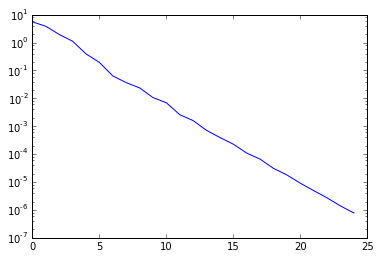

In [11]:
%pylab inline
import pylab
import numpy

A=numpy.array([[10., 2., 3., 5.],[1., 14., 6., 2.],[-1., 4., 16., -4],[5. ,4. ,3. ,11. ]])
b = numpy.array([1., 2., 3., 4.])
print(A.shape[0])

# an initial guess at the solution - here vector of zeros of length the number of rows in A
x = numpy.zeros(A.shape[0]) 

tol = 1.e-6 # iteration tolerance
it_max = 1000 # upper limit on iterations if we don't hit tolerance
residuals=[] # store residuals

for it in range(it_max):
    x_new = numpy.zeros(A.shape[0])  # initialise the new solution vector
    for i in range(A.shape[0]):
        x_new[i] = (1./A[i, i]) * (b[i] - numpy.dot(A[i, :i], x[:i]) - numpy.dot(A[i, i + 1:], x[i + 1:]))

    residual = numpy.linalg.norm(numpy.dot(A, x) - b)  # calculate the norm of the residual r=Ax-b for this latest guess
    residuals.append(residual) # store it for later plotting
    if (residual < tol): # if less than our required tolerance jump out of the iteration and end.
        break

    x = x_new # update old solution

pylab.semilogy(residuals) # plot the log of the residual against iteration number 
print(x_new) # our solution vector
print(numpy.dot(linalg.inv(A),b))  # check against scipy

## Iterative methods - Gauss-Seidel's method

We can make a small improvement to Jacobi's method using the updated components of the solution vector as they become available:

* Starting from a guess at the solution $\pmb{x}^{(0)}$

* iterate for $k>0$
$$x_i^{(k)} = \frac{1}{A_{ii}}\left(b_i- \sum_{\substack{j=1\\ j< i}}^nA_{ij}x_j^{(k)} - \sum_{\substack{j=1\\ j> i}}^nA_{ij}x_j^{(k-1)}\right),\quad  i=1,2,\ldots, n.$$

Note that as opposed to Jacobi, we can overwrite the entries of $\pmb{x}$ as they are updated, with Jacobi we need to store both the new as well as the old iteration.

The Gauss-Seidel algorithm should converge faster than Jacobi, but this convergence can only be *guaranteed* for matrices which are diagonally dominant (for every row, the magnitude of value on the main diagonal is greater than the sum of the magnitudes of all the other entries in that row), or if the matrix is *symmetric positive definite* (a property we won't define in this course).  



### <span style="color:blue">Exercise 7.3: Implement Gauss-Seidel's method.</span>

Generalise the Jacobi code to solve the matrix problem using Gauss-Seidel's method.

In [61]:
import numpy as np
import scipy.linalg as sl


def gauss_seidel(A, b, maxit=500):
    m, n = A.shape
    x = np.zeros_like(b)
    for k in range(maxit):
        for i in range(m):
            x[i] = 1/A[i,i] * (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,i+1:], x[i+1:]))
    return x


A = numpy.array([[10., 2., 3., 5.],
                 [1., 14., 6., 2.],
                 [-1., 4., 16.,-4],
                 [5. ,4. ,3. ,11.]])
b = numpy.array([1., 2., 3., 4.])
np.allclose(np.dot(sl.inv(A),b), gauss_seidel(A, b))

[-0.16340816 -0.01532706  0.27335264  0.36893555]


True

## Sparse matrices

Note that the matrices which result from the numerical solution of differential equations are generally  *sparse* (<https://en.wikipedia.org/wiki/Sparse_matrix>) which means that most entries are zero (the alternative is termed *dense*).  Knowing which entries are zero means that we can devise more efficient matrix storage methods, as well as more efficient implementations of the above algorithms.

As an example, for the two iterative methods shown above (Jacobi and Gauss Seidel), the cost of each iteration is quadratically dependent on the number of unknowns $n$, since we need to loop through all the entries of the $n\times n$ matrix $A$. For a fixed number of iterations the computational cost of these methods therefore scales as $n^2$. If we know that each row only contains a fixed, small number of non-zero entries however (as for example the matrix in the last exercise), we can simply skip the zero entries and the cost *per iteration* becomes linear in $n$. These scalings of $n^2$ for *dense* and $n$ for *sparse* matrices for the cost per iteration are typical for iterative methods. Unfortunately this does not mean that the overall cost of an iterative method is also $n^2$ or $n$, as the number of iterations that is needed to achieve a certain accuracy quite often also increases for bigger problem sizes. The number of required iterations typically only increases very slowly however, so that the cost of the method is still considerably cheaper than direct methods, in particular for very large problems.

A huge range of iterative solution methods exist and the literature on this topic is massive. Below is an example of using scipy to access the Conjugate Gradient algorithm which is a popular example of a method suitable for matrices which result from the numerical solution of differential equations.

In [2]:
import numpy
import scipy.sparse.linalg

n=50
main_diag = numpy.ones(n)
off_diag = numpy.random.random(n-1)  # to make it a bit more interesting make the off-diagonals random
A = numpy.diag(-2*main_diag,0) + numpy.diag(1.*off_diag,1) + numpy.diag(1.*off_diag,-1)
# A random RHS vector
b = numpy.random.random(A.shape[0])

print A # print our A in "dense" matrix format

sA = scipy.sparse.csr_matrix(A) # The same matrix in a "sparse" matrix data structure where only non-zeros stored
print sA

# now use a scipy iterative algorithm (Conjugate Gradient) to solve

# First define a function which we will pass the the solver in order to store and print the iteration numbers and residuals
def gen_callback_cg():
    diagnostics = dict(it=0, residuals=[]) 
    def callback(xk):   # xk is the solution computed by CG at each iteration
        diagnostics["it"] += 1
        diagnostics["residuals"].append(numpy.linalg.norm(numpy.dot(A, xk) - b))
        print(diagnostics["it"], numpy.linalg.norm(numpy.dot(A, xk) - b))
    return callback    

x_sol = scipy.sparse.linalg.cg(A,b,x0=None, tol=1e-10, maxiter=1000, callback=gen_callback_cg())

[[-2.          0.61882841  0.         ...,  0.          0.          0.        ]
 [ 0.61882841 -2.          0.66655965 ...,  0.          0.          0.        ]
 [ 0.          0.66655965 -2.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ..., -2.          0.22501949  0.        ]
 [ 0.          0.          0.         ...,  0.22501949 -2.          0.86267149]
 [ 0.          0.          0.         ...,  0.          0.86267149 -2.        ]]
  (0, 0)	-2.0
  (0, 1)	0.618828414276
  (1, 0)	0.618828414276
  (1, 1)	-2.0
  (1, 2)	0.666559653751
  (2, 1)	0.666559653751
  (2, 2)	-2.0
  (2, 3)	0.291319892756
  (3, 2)	0.291319892756
  (3, 3)	-2.0
  (3, 4)	0.770110321377
  (4, 3)	0.770110321377
  (4, 4)	-2.0
  (4, 5)	0.0454034205716
  (5, 4)	0.0454034205716
  (5, 5)	-2.0
  (5, 6)	0.140440902887
  (6, 5)	0.140440902887
  (6, 6)	-2.0
  (6, 7)	0.569533654337
  (7, 6)	0.569533654337
  (7, 7)	-2.0
  (7, 8)	0.190283158038
  (8, 7)	0.190283158038
  (8, 8)	-2.0


## Example

Let us consider an electric circuit arranged in a regular grid of $n$ rows and $m$ columns. The nodes in the grid are numbered from 0 to $nm-1$ as indicated in the diagram below.

![bla](images/circuit.png)

We want to calculate the electric potential $V_i$ in all of the nodes $i$. A node $i$ somewhere in the middle of the circuit is connected via resistor to nodes $i-1$ and $i+1$ to the left and right respectively, and to the nodes $i-m$ and $i+m$ in the rows above and below. For simplicity we assume that all resistors have the same resistance value $R$. The first and last node of the circuit (0 and $nm-1$) to a battery via two additional resistors, with the same resistance value $R$.

The sum of the currents coming into a node is zero (if we use a sign convention where a current coming into a node is positive and a current going out is negative. The currents between two nodes can be calculated using Ohm's law: $I=V/R$ where $R$ is the resistance of the resistor, and $V$ is the potential difference between two nodes, say $V=V_i-V_{i-1}$. Therefore we can write:

\begin{eqnarray}
  0 &=& I_{i-1\to i} + I_{i+1\to i} + I_{i-m\to i} + I_{i+m\to i} \\
    &=& V_{i-1\to i}/R + V_{i+1\to i}/R + V_{i-m\to i}/R + V_{i+m\to i}/R \\
    &=& (V_{i}-V_{i-1})/R + (V_{i}-V_{i+1})/R + (V_{i}-V_{i-m})/R + (V_{i}-V_{i+m})/R \\
    &=& (4V_{i}-V_{i-1}-V_{i+1}-V_{i-m}-V_{i+m})/R
\end{eqnarray}

This gives us one linear equation for each node in the circuit (with slight modifications for nodes that are not in the interior). These can be combined into a linear system $Ax=b$ which is assembled in the code below:

In [14]:
n = 4 # number of rows
m = 3 # number of columns
V_battery = 5.0 # voltage on the right of the battery

A = numpy.zeros((n*m, n*m))
for row in range(n):
    for column in range(m):
        i = row*m + column # node number
        if column>0: # left neighbour
            A[i,i-1] += -1.0
            A[i,i] += 1.0
        if column<m-1: # right neighbour
            A[i,i+1] += -1.0
            A[i,i] += 1.0
        if row>0: # neighbour above
            A[i,i-m] += -1.0
            A[i,i] += 1.0
        if row<n-1: # neighbour below
            A[i,i+m] += -1.0
            A[i,i] += 1.0

# connecting node 0 to the battery: I = (V_0 - 0)/R
A[0,0] += 1.0 
# connecting last node nm-1 to the battery: I = (V_0 - V_battery)/R = V_0/R - V_battery/R
A[n*m-1,n*m-1] += 1.0
# the V_battery/R term is a constant that does not depend on the unknowns, so ends up in the rhs vector b
b = numpy.zeros(n*m)
b[n*m-1] = V_battery